### Author: Roberto Mendoza
### Date: 03/03/2020


In [1]:
import Pkg


In [2]:
## Install package 

#import Pkg; Pkg.add("CairoMakie")
#import Pkg; Pkg.add("Plots")
#import Pkg; Pkg.add("Distributions")
#import Pkg; Pkg.add("HypothesisTests")
#Pkg.add("ClinicalTrialUtilities")
using CairoMakie  # for density plot 
using ClinicalTrialUtilities
using Random   # for random seeds
using Statistics 
using Distributions
using HypothesisTests
using Images, FileIO

## 1.0 RCT application Polio  vaccination 

One of the earliest randomized experiments were the Polio vaccination trias conducted by the Public Health Service in 1954. The question was whether Salk vaccine prevented polio. Children in the study were randomly assigned either a treatment (polio vaccine shot) or a placebo (saline solution shot), without knowing which one they received. The doctors in the study, making the diagnosis, did not know whether a child received a vaccine or not. In other words, the trial was a double-blind, randomized control trial. The trial had to be large, because the rate at which Polio occured in the population was 50 per 100,000. The treatment group saw 33 polio cases per 200,745; the control group saw 115 cases per 201,229. The estimated avearage treatment effect is about

$$-40$$

with the 95% confidence band (based on approximate normality of the two sample means and their differences):

$$[−52,−28]$$
 
As this is an RCT, the confidence band suggests that the Polio vaccine caused the reduction in the risk of polio.

The interesting thing here is that we don't need the underlying individual data to evaluate the effectivess of the vaccine. This is because the outcomes are Bernoulli random variables, and we have enough information to compute the estimate of ATE as well as the confidence intervals from the group case counts.

We also compute the Vaccine Efficacy metric, which refers to the following measure according to the CDC:

$$VE=\frac{Risk for Unvaccinated - Risk for Vaccinated}{Risk for Unvaccinated}$$
 
It describes the relative reduction in risk caused by vaccination.

It is staighforward to get the VE estimate by just plugging-in the numbers, but how do we get the approximate variance estimate? I am too lazy to do calculations for the delta method, so I will just use a simulation (a form of approximate bootstrap) to obtain the confidence intervals.

In [6]:
NV = 200745 # number of vaccinated (treated)
NU = 201229 # number of unvaccinated (control)
RV= 33/NV  # average outcome for vaccinated
RU =115/NU  # average outcome for unvaccinated
VE = (RU - RV)/RU # vaccine efficacy

0.7123516206478694

In [7]:
## Incidence per 100000

n = 100000

IncidenceRV = RV*n
IncidenceRU = RU*n

#Treatment effect - estimated reduction in incidence of polio per 100000 people

ATE_hat = n*(RV-RU)

println("Incidence per 100000 among treated: ", round(IncidenceRV; digits =4))

println("Incidence per 100000 among untreated: ", round(IncidenceRU; digits =4))

println("Estimated ATE of occurances per 100,000 is: ", round(ATE_hat; digits =4))

Incidence per 100000 among treated: 16.4388
Incidence per 100000 among untreated: 57.1488
Estimated ATE of occurances per 100,000 is: -40.7101


In [8]:
# outcomes (RV, RU) are Bernoulli
# variance, standard deviation and confidence interval of ATE 

var_RV = RV*(1-RV)/NV
var_RU = RU*(1-RU)/NU

var_ATE_hat  = n^2*(var_RV+var_RU)

std_ATE_hat = sqrt(var_ATE_hat)

println("Standard deviation for ATE is:  ", round(std_ATE_hat; digits =4))



Standard deviation for ATE is:  6.0474


In [9]:
# Confidence interval 

CI_ATE_hat =[ round(ATE_hat - 1.96*std_ATE_hat; digits = 4), round(ATE_hat + 1.96*std_ATE_hat; digits = 4)]

println("95% confidence interval of ATE is $CI_ATE_hat")

println("Overall VE is: " , round(VE; digits =4))

95% confidence interval of ATE is [-52.563, -28.8571]
Overall VE is: 0.7124


In [10]:
# Confidence interval based on approximate bootstrap

# Monte Carlo draws

Random.seed!(1)

B = 10000 #  number of boostraps
RVs = RV*ones(Float16, B)  + randn(B)*sqrt(var_RV)
RUs = RU*ones(Float16, B)  + randn(B)*sqrt(var_RU)
VEs= (RUs - RVs)./RUs


10000-element Vector{Float64}:
 0.6817224261974857
 0.6953664347250816
 0.7531459258609844
 0.6867222213078893
 0.6165362111226124
 0.7817779666902431
 0.6333934469608703
 0.6556843828007883
 0.8379647737634552
 0.8132928763558297
 0.6864550692620768
 0.729847409124033
 0.6893974356034072
 ⋮
 0.7124512490775646
 0.743478827635636
 0.6243684604532374
 0.7093989620521691
 0.7272183082401089
 0.588658896827336
 0.6917235071731522
 0.7243046193192478
 0.7552945654793395
 0.753296520825968
 0.727182181643485
 0.8022899199587447

two-sided 95% confidence interval of VE is [0.59, 0.8179]


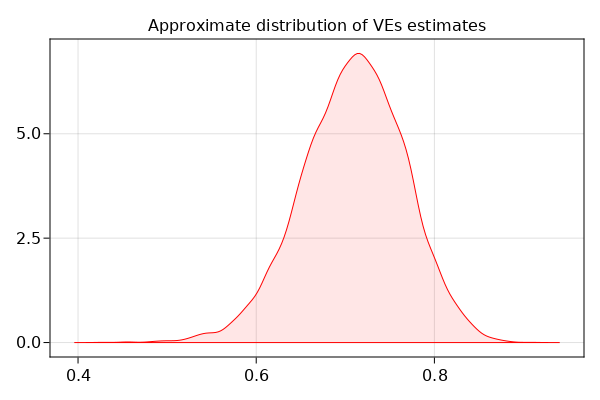

In [11]:
## Confidence interval of VEs

CI_VE = [round(quantile!(VEs, 0.025); digits = 4 ), round(quantile!(VEs, 0.975); digits = 4)]

println("two-sided 95% confidence interval of VE is $CI_VE")

## Approximate distribution of VEs estimates 

f = Figure(resolution = (600, 400))
Axis(f[1,1], title = "Approximate distribution of VEs estimates ")
    
density!(VEs, color = (:red, 0.1), strokecolor = :red, strokewidth = 1, strokearound = true, bandwidth = 0.008257) 

f


## 2.0 Pfizer/BNTX Covid-19 RCT application

Pfizer/BNTX was the first vaccine approved for emergency use to reduce the risk of Covid-19 decease. In studies to assess vaccine efficacy, volunteers were randomly assigned to receive either a treatment (2-dose vaccination) or a placebo, without knowing which they recieved. The doctors making the diagnoses did not know now whether a given volunteer received a vaccination or not. The results of the study are given in the following table.





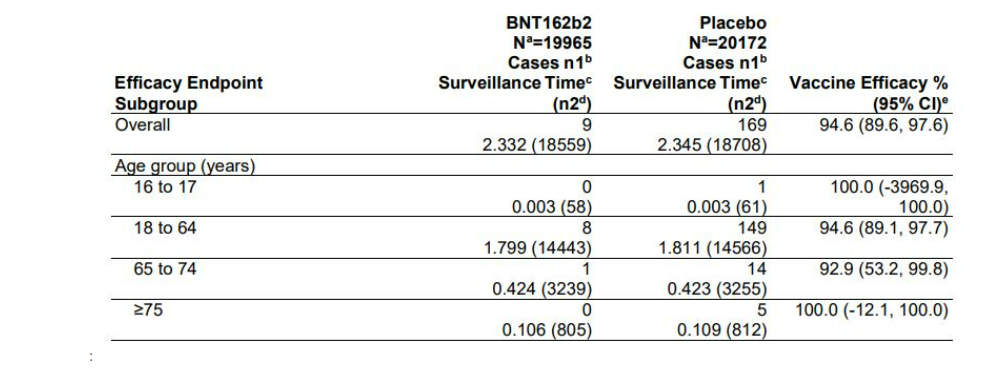

In [37]:
img_path = "../data/imagen_RCT.png"
img = load(img_path)
imresize(img, ratio=1)

Here we see both the overall effects and the effects by age group. The confidence intervals for the overall ATE are tight and suggest high effectiveness of the vaccine. The confidence intervals for the age group 65-75 are much wider due to the relatively small number of people in this group. We could group 65-75 and >75 groups to evaluate the effectiveness of the vaccine for this broader age group and narrow the width of the confidence band.

We use the same approach as that for the Polio example. This gives slightly different results than the FDA result, because the FDA used inversion of exact binomial tests to construct confidence intervals. We use asymptotic approches based on approximate normality, which is more crude, but delivers a rather similar result.

In [13]:
# define inputs 

NV =  19965; # number vaccinated
NU =  20172; # number unvaccinated
RV = 9/NV; # average outcome for vaccinated
RU = 169/NU; # average outcome for unvaccinated
VE = (RU - RV)/RU; # vaccine efficacy


In [14]:
## Incidence per 100000

n = 100000

IncidenceRV = RV*n
IncidenceRU = RU*n

#Treatment effect - estimated reduction in incidence of polio per 100000 people

ATE_hat = n*(RV-RU)

println("Incidence per 100000 among treated: ", round(IncidenceRV; digits =4))

println("Incidence per 100000 among untreated: ", round(IncidenceRU; digits =4))

println("Estimated ATE of occurances per 100 000 is: ", round(ATE_hat; digits =4))

Incidence per 100000 among treated: 45.0789
Incidence per 100000 among untreated: 837.795
Estimated ATE of occurances per 100 000 is: -792.7161


In [15]:
# outcomes (RV, RU) are Bernoulli
# variance, standard deviation and confidence interval of ATE 

var_RV = RV*(1-RV)/NV
var_RU = RU*(1-RU)/NU

var_ATE_hat  = n^2*(var_RV+var_RU)

std_ATE_hat = sqrt(var_ATE_hat)

println("Standard deviation for ATE is:  ", round(std_ATE_hat; digits =4))


Standard deviation for ATE is:  65.9102


In [16]:
# Confidence interval 

CI_ATE_hat =[ round(ATE_hat - 1.96*std_ATE_hat; digits = 4), round(ATE_hat + 1.96*std_ATE_hat; digits = 4)]

println("95% confidence interval of ATE is $CI_ATE_hat")

println("Overall VE is: " , round(VE; digits =4))

95% confidence interval of ATE is [-921.9, -663.5322]
Overall VE is: 0.9462


### 2.1 Approximate bootstrap to find the VE confidence interval

In [17]:
Random.seed!(1)

B = 10000 #  number of boostraps
RVs = RV*ones(Float16, B)  + randn(B)*sqrt(var_RV)
RUs = RU*ones(Float16, B)  + randn(B)*sqrt(var_RU)
VEs= (RUs - RVs)./RUs


10000-element Vector{Float64}:
 0.9408814093514811
 0.9407141481447149
 0.9583954955606354
 0.9418011045721292
 0.9195806666751577
 0.9735151090522808
 0.9324119521198911
 0.9283966354436475
 0.9959369160363154
 0.9806489086264251
 0.9399270593044702
 0.9558969100456748
 0.9398759241059838
 ⋮
 0.9572265468704411
 0.9589555046200413
 0.9254816573864182
 0.9433292399034574
 0.9494612927672281
 0.9006061197052284
 0.9342904269034605
 0.9500620084283901
 0.9592797266834576
 0.9541960000272378
 0.9499975261585338
 0.9728994198085604

two-sided 95% confidence interval of VE is [0.9081, 0.9817]


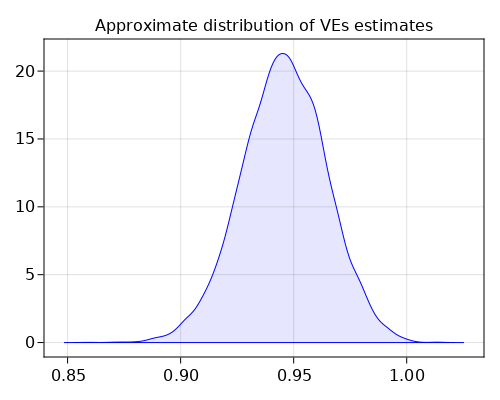

In [18]:
## Confidence interval of VEs

CI_VE = [round(quantile!(VEs, 0.025); digits = 4 ), round(quantile!(VEs, 0.975); digits = 4)]

println("two-sided 95% confidence interval of VE is $CI_VE")

## Approximate distribution of VEs estimates 

f = Figure(resolution = (500, 400))
Axis(f[1,1], title = "Approximate distribution of VEs estimates ")
    
density!(VEs, color = (:blue, 0.1), strokecolor = :blue, strokewidth = 1, strokearound = true) 

f

## 3.0 Overall effectiveness of the vaccine for the two groups (treatment and control) that are 65 or older

In [19]:
NV =  3239+805;
NU =  3255+812;
RV = 1/NV;
RU = (14+5)/NU;
VE = (RU - RV)/RU;

println("Overall VE is: " , round(VE; digits =4))

var_RV = RV*(1-RV)/NV
var_RU = RU*(1-RU)/NU

Overall VE is: 0.9471


1.1433299694990984e-6

### 3.1  Approximate bootstrap to find the VE confidence interval

In [20]:
Random.seed!(1)

B = 10000 #  number of boostraps

RVs = RV*ones(Float16, B)  + randn(B)*sqrt(var_RV) + 10^(-10)*ones(Float16, B) 
RUs = RU*ones(Float16, B)  + randn(B)*sqrt(var_RU) + 10^(-10)*ones(Float16, B) 
VEs= (RUs - RVs)./RUs



10000-element Vector{Float64}:
 0.9286374701019094
 0.9306318821603504
 0.9807062047067295
 0.932227928439073
 0.8497213956232972
 1.0341633458705015
 0.8826086276184276
 0.8908920202231071
 1.1204683874016654
 1.0436392904285337
 0.9269669930323389
 0.978832510418485
 0.9274269094457963
 ⋮
 0.9941031787120717
 0.9865853448694472
 0.8630160479950865
 0.939002630393595
 0.9561668577648301
 0.8166249965881008
 0.9157406832836444
 0.9583524341261762
 0.983253521851282
 0.9668034744043027
 0.9578251425652174
 1.0144231014448826

two-sided  95% confidence interval of VE is [0.8162, 1.0532]
one side 95% confidence interval of VE is [0.8422, 1.0]


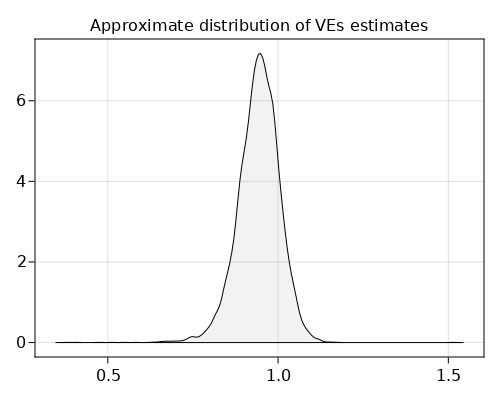

In [21]:
## Confidence interval of VEs

CI_VE = [round(quantile!(VEs, 0.025); digits = 4 ), round(quantile!(VEs, 0.975); digits = 4)]

OneSidedCI_VE = [round(quantile!(VEs, 0.05); digits = 4 ), 1]

println("two-sided  95% confidence interval of VE is $CI_VE")

println("one side 95% confidence interval of VE is $OneSidedCI_VE")

## Approximate distribution of VEs estimates 

f = Figure(resolution = (500, 400))
Axis(f[1,1], title = "Approximate distribution of VEs estimates ")
    
density!(VEs, color = (:gray, 0.1), strokewidth = 1, strokearound = true) 

f

### Let's try the parametric boostrap next, using the fact that the outcome is Bernouli.

In [22]:
NV =  3239+805;
NU =  3255+812;
RV = 1/NV;
RU = (14+5)/NU;
VE = (RU - RV)/RU;

println("Overall VE is: " , round(VE; digits =4))

Overall VE is: 0.9471


In [23]:
Random.seed!(1)

B = 10000 #  number of boostraps
VEs= (RUs - RVs)./RUs

RVs = rand(Binomial(NV,RV), B)
RUs = rand(Binomial(NU,RU), B)
VEs= (RUs - RVs)./RUs

10000-element Vector{Float64}:
 0.95
 1.0
 1.0
 1.0
 0.9375
 1.0
 0.8333333333333334
 0.8666666666666667
 0.9473684210526315
 0.8235294117647058
 1.0
 0.9375
 0.95
 ⋮
 0.7857142857142857
 0.9
 0.95
 0.9444444444444444
 0.9230769230769231
 1.0
 0.9333333333333333
 0.8947368421052632
 0.8888888888888888
 1.0
 0.9473684210526315
 0.8888888888888888

two-sided 95% confidence interval of VE is [0.8, 1.0]
one sided 95% confidence interval of VE is [0.8333, 1.0]


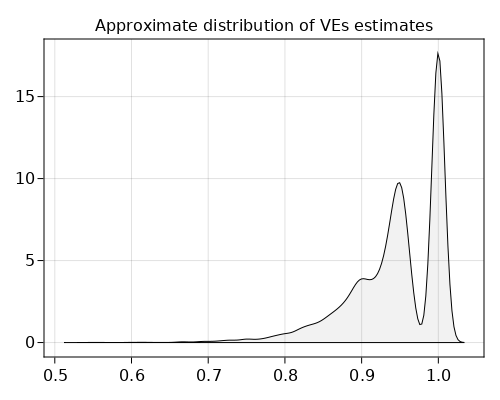

In [24]:
## Confidence interval of VEs

CI_VE = [round(quantile!(VEs, 0.025); digits = 4 ), round(quantile!(VEs, 0.975); digits = 4)]

OneSidedCI_VE = [round(quantile!(VEs, 0.05); digits = 4 ), 1]

println("two-sided 95% confidence interval of VE is $CI_VE")

println("one sided 95% confidence interval of VE is $OneSidedCI_VE")

## Approximate distribution of VEs estimates 

f = Figure(resolution = (500, 400))
Axis(f[1,1], title = "Approximate distribution of VEs estimates ")
    
density!(VEs, color = (:gray, 0.1), strokewidth = 1, strokearound = true) 

f

## 4.0 Exact Binomial Test Inversion

In [32]:
# Exact CI exploiting Bernoulli outcome using the Cornfield Procedure

NV =  19965;
NU =  20172;
RV = 9/NV;
RU = 169/NU;
VE = (RU - RV)/RU;

confint = orpropci(9::Int, NV::Int, 169::Int, NU::Int; alpha = 0.05)::ConfInt


Estimate: 0.053379861731311845 (0.027616272602670834 - 0.10317864685976501)

In [33]:
l=1-0.027616272602670834
u=1-0.10317864685976501
confint = (l,u)

(0.9723837273973291, 0.896821353140235)

- Note that this exactly recovers the result in the FDA table (first row).
- Next we repeat the cornfield procedure to find the exact confidence interval on vaccine effectiveness for the two groups that are 65 or older. Here we see a big discrepancy between various asymptotic approaches and the exact finite-sample inference. This occurs because the binomial counts are too low for central limit theorems to work successfully.

In [36]:
# Exact CI exploiting Bernoulli outcome for the two groups that are 65 or older

NV =  3239+805;
NU =  3255+812;
RV = 1/NV;
RU = (14+5)/NU;
VE = (RU - RV)/RU;

confint = orpropci(1::Int, NV::Int, 19::Int, NU::Int; alpha = 0.05)::ConfInt


Estimate: 0.05269666870614577 (0.00896277602085047 - 0.30983022294266616)

In [35]:
l=1-0.00896277602085047
u=1-0.30983022294266616
confint = (l,u)

(0.9910372239791495, 0.6901697770573338)